# Mount with your google drive

In [72]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/computer_vision/project

%matplotlib inline 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/computer_vision/project'
/content/drive/MyDrive/computer_vision/project


# Load image
should be sky segmented image

(3456, 4608, 3)


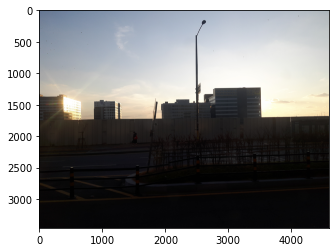

In [73]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import copy
from PIL import Image

assert os.getcwd()=='/content/drive/My Drive/computer_vision/project', 'Directory should be "/content/drive/My Drive/computer_vision/project" instead of "{}"'.format(os.getcwd())

data_dir = 'data/'
filename = 'image5'
img = cv2.imread(data_dir+filename+'.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

plt.imshow(img)
plt.show()

# Sky Segmentation
**Implemented by cnelson**

A Python implementation of [Sky Region Detection in a Single Image for Autonomous Ground Robot Navigation (Shen and Wang, 2013)](https://journals.sagepub.com/doi/full/10.5772/56884)

In [74]:
import cv2
import numpy as np
from scipy import spatial


def make_mask(b, image):
    mask = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.uint8)
    for xx, yy in enumerate(b):
        mask[yy:, xx] = 255

    return mask

def color_to_gradient(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.hypot(
        cv2.Sobel(gray, cv2.CV_64F, 1, 0),
        cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    )

def energy(b_tmp, image):
    sky_mask = make_mask(b_tmp, image)

    ground = np.ma.array(
        image,
        mask=cv2.cvtColor(cv2.bitwise_not(sky_mask), cv2.COLOR_GRAY2BGR)
    ).compressed()
    sky = np.ma.array(
        image,
        mask=cv2.cvtColor(sky_mask, cv2.COLOR_GRAY2BGR)
    ).compressed()
    ground.shape = (ground.size//3, 3)
    sky.shape = (sky.size//3, 3)

    sigma_g, mu_g = cv2.calcCovarMatrix(
        ground,
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )
    sigma_s, mu_s = cv2.calcCovarMatrix(
        sky,
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )

    y = 2

    return 1 / (
        (y * np.linalg.det(sigma_s) + np.linalg.det(sigma_g)) +
        (y * np.linalg.det(np.linalg.eig(sigma_s)[1]) +
            np.linalg.det(np.linalg.eig(sigma_g)[1]))
    )

def calculate_border(grad, t):
    sky = np.full(grad.shape[1], grad.shape[0])

    for x in range(grad.shape[1]):
        border_pos = np.argmax(grad[:, x] > t)

        # argmax hax return 0 if nothing is > t
        if border_pos > 0:
            sky[x] = border_pos

    return sky

def calculate_border_optimal(image, thresh_min=5, thresh_max=600, search_step=5):
    grad = color_to_gradient(image)

    n = ((thresh_max - thresh_min) // search_step) + 1

    b_opt = None
    jn_max = 0

    for k in range(1, n + 1):
        t = thresh_min + ((thresh_max - thresh_min) // n - 1) * (k - 1)

        b_tmp = calculate_border(grad, t)
        jn = energy(b_tmp, image)

        if jn > jn_max:
            jn_max = jn
            b_opt = b_tmp

    return b_opt

def detect_sky(image):
    bopt = calculate_border_optimal(image)
    return bopt

Sky segmentation
Elapsed time : 140.24140572547913


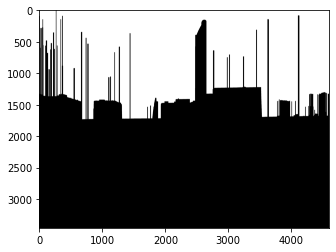

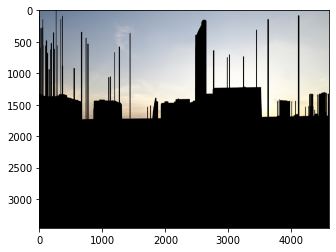

In [75]:
import time
import copy

print("Sky segmentation")

start = time.time()        

h,w = img.shape[:2]
border = detect_sky(img)
mask = np.zeros((h,w), np.uint8)
for i,b in enumerate(border):
  for j in range(b):
    mask[j,i] = 255

kernel = np.ones((10,10),np.uint8)
mask = cv2.erode(mask,kernel)

end = time.time()
print("Elapsed time : {}".format(end - start))

plt.imshow(mask, cmap='gray')
plt.show()

img = cv2.bitwise_or(img, img, mask=mask)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite('results/'+filename+'_mask.jpg', img)

plt.imshow(cv2.cvtColor(copy.deepcopy(img), cv2.COLOR_BGR2RGB))
plt.show()


# Prerequisite
1. f
2. theta_c
3. Assume no roll

In [76]:
f = 1000
theta_c = 0

# Functions 
1. calculate angle from pixel
2. calculate relative luminance
3. calculate likelihood

In [77]:
phi_c = 0

# calculate theta_p, gamma_p
def theta_and_gamma(u,v,f,theta_s, phi_s):
  theta_p = np.arccos((v * np.sin(theta_c) + f * np.cos(theta_c))/np.sqrt(u**2 + v**2 + f**2))
  foo = f*np.sin(phi_c)*np.sin(theta_c) - u*np.cos(phi_c) - v*np.sin(phi_c)*np.cos(theta_c)
  bar = f*np.cos(phi_c)*np.sin(theta_c) + u*np.sin(phi_c) - v*np.cos(phi_c)*np.cos(theta_c)
  phi_p = np.arctan(foo/bar)
  gamma_p = np.arccos(np.cos(theta_s)*np.cos(theta_p) + np.sin(theta_s)*np.sin(theta_p)*np.cos(phi_p-phi_s))
  return theta_p, gamma_p

In [78]:
# given theta_s, phi_s ==> calculate relative luminance
# clear sky model (perez)
a = -1
b = -0.32
c = 10
d = -3
e = 0.45

def relative_luminance(u, v, f, theta_s, phi_s):
  theta, gamma = theta_and_gamma(u,v,f,theta_s,phi_s)
  l = (1 + a * np.exp(b/np.cos(theta))) * (1 + c * np.exp(d*gamma) + e * (np.cos(gamma)**2))
  return l

In [79]:
# assume gaussian distribution N(kg(theta_s, phi_s), sigma**2)
# given one pixel and k, theta_s, phi_s ==> calculate likelihood

def log_likelihood(s, u, v, f, k, theta_s, phi_s, sigma = 1.0):
  L = k * relative_luminance(u, v, f, theta_s, phi_s)
  ret = - ((s - L) ** 2) / (2 * (sigma**2))
  return ret


# Maximum likelihood estimation
1. choose sky region
2. discretize the parameter space (k, theta_s, phi_s)
3. calculate likelihood

In [83]:
sky = []
step = 100
for x in range(0,h,step):
  for y in range(0,w,step):
    if img[x,y,0] == 0 and img[x,y,1] == 0 and img[x,y,2] == 0:
      continue
    sky.append((x,y))
print("Select {} sky pixels".format(len(sky)))

Select 656 sky pixels


In [92]:
k_len = 5
theta_len = 10
phi_len = 40

k_list = np.exp(np.linspace(0,5,k_len))
theta_list = np.linspace(0,np.pi/2,theta_len)
phi_list = np.linspace(0,2*np.pi,phi_len)

In [93]:
import time

likelihood_space = np.zeros((k_len, theta_len, phi_len))
h,w = img.shape[:2]

start = time.time()

for kIdx,k in enumerate(k_list):
  for thetaIdx,theta in enumerate(theta_list):
    for phiIdx,phi in enumerate(phi_list):
      for x,y in sky:
        u = y - w/2
        v = x - h/2
        s = np.linalg.norm(img[x,y])
        log_prob = log_likelihood(s, u, v, f, k, theta, phi)
        likelihood_space[kIdx,thetaIdx,phiIdx] += log_prob
        
end = time.time()
print("Elapsed time : {}".format(end - start))
likelihood_space = np.amax(likelihood_space, axis = 0)

flatten_index = np.argmax(likelihood_space)
theta_index = flatten_index // phi_len
phi_index = flatten_index % phi_len
print("theta : {}, phi : {}".format(theta_list[theta_index]/np.pi*180, phi_list[phi_index]/np.pi*180))

Elapsed time : 67.67408776283264
theta : 40.0, phi : 323.07692307692304


-10415717.427893654
-26620360.451146033


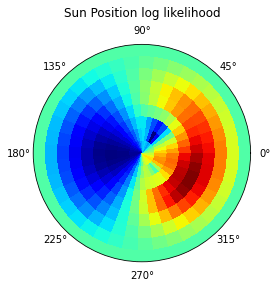

In [94]:
import numpy as np

%matplotlib inline

ax = plt.subplot(1, 1, 1, projection='polar')
mx = np.max(likelihood_space)
mn = np.min(likelihood_space)
z = (likelihood_space - mn) / (mx-mn)
cmap = plt.get_cmap('jet')
plt.pcolormesh(phi_list, np.pi/2 - theta_list, z, cmap = cmap)
ax.set_title('Sun Position log likelihood', position=(0.5, 1.1))
ax.set_rlim(0,np.pi/2)
ax.axes.get_yaxis().set_visible(False)
plt.savefig('results/'+filename+'_result.jpg')